# Affichage en diagramme de Gantt d'un ordonnancement 

L'objectif est d'utiliser et modifier les fonctions d'ordonnancement, de coût et d'affichage pour pouvoir visualiser un planning sous forme de Gantt.


On prend en compte le nombre de ressources que l'on connait de l'hôpital actuel, mais on ne prend pas en compte tout de suite les correspondances patient-médecin et les vacations réelles (on considère qu'ils sont tous toujours disponibles). On améliorera ceci plus tard.

Vocabulaire utilisé : 

- 'Ordonnancement' : liste de temps de prise en charge de patients sous la forme [ [ tempsBrancardage, tempsSSPIEntree, tempsBloc, tempsSSPIRéveil ] pour chaque patient ]
- 'Phase' : Une phase désigne une des 4 phases de prise en charge d'un patient (Brancardage, SSPIEntree, Bloc, SSPIRéveil)
- 'Ressource' : Une ressource désigne l'une des "machines" réelles qui prennent en charge le patient (ex: Brancardier 1, lit d'entrée 3, Bloc 4, Lit de réveil 2)
- 'Patient' : Un patient correspond à un tuple (identifiant patient, début tache dans la phase, duree tache dans la phase), cette donnée est différente d'une phase à l'autre pour un même patient
- 'Arrangement' : Regroupement de l'ordre de passage des patients pour chaque phase et leurs ressources, avec les patients au format ci-dessus

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import copy 

In [242]:
def genOrdo(n_patient):
    """Génère un ordonnancement au hasard -> Sert uniquement en test"""
    
    return [[random.randint(5,10),random.randint(10,30),random.randint(40,120),random.randint(10,30)] for _ in range(n_patient)]

def choixRessource(phase):
    """Soit phase une liste de ressources, cette fonction détermine quelle ressource prend la tâche"""
    
    mini = phase[0][-1][1]+phase[0][-1][2]
    index = 0
    
    found = False
    iRessource = 0
    
    while (not found) and iRessource < len(phase):
        ressource = phase[iRessource]
        if ressource == [(0,0,0)]:
            found = True
            index = iRessource
        elif ressource[-1][1]+ressource[-1][2] < mini:
            mini = ressource[-1][1]+ressource[-1][2]
            index = iRessource
        iRessource+=1
            
    return index

def choixSSPIReveil(ordresSSPIReveils, ordresBlocs, ind, dureeTache):
    """Choix du lit de SSPI de réveil (processus légèrement différent des autres phases)"""
    
    mini = ordresSSPIReveils[0][-1][1]+ordresSSPIReveils[0][-1][2]
    index = 0
    advanced = False
    
    found = False
    iRessource = 0
    
    while (not found) and (iRessource < len(ordresSSPIReveils)):
        ressource = ordresSSPIReveils[iRessource]
        blocPhase = searchPatient(ind, ordresBlocs)
        if ressource == [(0,0,0)]:
            found = True
            index = iRessource
        elif len(ressource) == 1 and (not advanced) :  # ce cas est à part car on compare qu'avec la fin du bloc et pas avec la tâche d'avant
            if (ressource[-1][1] - dureeTache >= blocPhase[1]+blocPhase[2]) : # s'il y a le temps de mettre le patient avant la dernière tâche affectée
                index = iRessource
                advanced = True
            elif ressource[-1][1]+ressource[-1][2] < mini:
                mini = ressource[-1][1]+ressource[-1][2]
                index = iRessource
        elif not advanced :
            if ressource[-1][1] - max(ressource[-2][1] + ressource[-2][2], blocPhase[1]+blocPhase[2]) >= dureeTache : # s'il y a le temps de mettre le patient avant la dernière tâche affectée
                index = iRessource
                advanced = True
            elif ressource[-1][1]+ressource[-1][2] < mini:
                mini = ressource[-1][1]+ressource[-1][2]
                index = iRessource
        iRessource+=1
            
    return index, advanced    # on renvoie l'index de la ressources choisie + si le patient a été avancé ou pas

def searchPatient(ind, phase):
    """Trouve le patient n°ind dans la phase *phase*"""
    
    found = False
    iPhase = 0
    
    while (not found) and iPhase < len(phase):
        ressource = phase[iPhase]
        iRessource = 0
        while iRessource < len(ressource):
            patient = ressource[iRessource]
            if patient[0] == ind:
                found = True
                reponse = patient
            iRessource += 1
        iPhase+=1
    
    if found:
        return reponse
    else: 
        return None
    
def decalPhase(ind, phase, delai):
    """Cette fonction décale d'un temps delai le patient ind dans la phase *phase*"""
    
    found = False
    iPhase = 0
    
    while (not found) and iPhase < len(phase):
        ressource = phase[iPhase]
        iRessource = 0
        while iRessource < len(ressource):
            patient = ressource[iRessource]
            if patient[0] == ind:
                found = True
                phase[iPhase][iRessource] = (phase[iPhase][iRessource][0], phase[iPhase][iRessource][1] + delai, phase[iPhase][iRessource][2]) # Un tuple n'est pas modifiable donc je dois le remplacer avec la nouvelle valeur
            iRessource += 1
        iPhase+=1
        

def arrangementFinal(ordo, nSSPIEntree = 2, nSSPIReveil = 2, nBloc = 4, nChir = 5, nAnesthesiste = 8, nBrancardier = 2):
    """Construit l'arrangement final en prenant en compte toutes les contraintes de ressources et de capacité"""
    
    # Initialisation des listes de phases qui représentent le passage 
    # des patients dans chaque 'phase' : dans chaque phase il y a nPhase ressources
    # et dans chaque ressource il y aura des patients au format (id du patient, instant de début de la tâche, duree de la tâche)
    
    ordresBrancardiers = [[(0, 0, 0)] for _ in range(nBrancardier)]
    ordresSSPIEntrees = [[(0, 0, 0)] for _ in range(nSSPIEntree)]
    ordresBlocs = [[(0, 0, 0)] for _ in range(nBloc)]
    ordresSSPIReveils = [[(0, 0, 0)] for _ in range(nSSPIReveil)]
    
    for ind, patient in enumerate(ordo):
        
        # Choix du bloc : attribution prioritaire car c'est ce qu'on optimise, et les autres taches en dépendent
        bloc = choixRessource(ordresBlocs)
        if ordresBlocs[bloc] == [(0, 0, 0)] :     # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
            ordresBlocs[bloc] = [(ind, 0, patient[2])]
        else :
            readyTime = ordresBlocs[bloc][-1][1] + ordresBlocs[bloc][-1][2] + 10
            ordresBlocs[bloc].append((ind, readyTime, patient[2]))
        
        # Choix du lit SSPI + attribution du patient:
        litSSPIEntree = choixRessource(ordresSSPIEntrees)
        blocPhase = searchPatient(ind, ordresBlocs) # On retrouve les données de ce patient au bloc
        if ordresSSPIEntrees[litSSPIEntree] == [(0,0,0)] :   # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
            ordresSSPIEntrees[litSSPIEntree] = [(ind, blocPhase[1]-patient[1], patient[1])]
        else : 
            readyTime = ordresSSPIEntrees[litSSPIEntree][-1][1] + ordresSSPIEntrees[litSSPIEntree][-1][2] # fin de la tâche précédente
            if readyTime + patient[1] < blocPhase[1] : # Si la tache a le temps d'être faite entre la fin de la précédente et le début du bloc
                ordresSSPIEntrees[litSSPIEntree].append((ind, blocPhase[1]-patient[1], patient[1]))
            else :     # Si on n'a pas le temps, il faut décaler le bloc
                decalPhase(ind, ordresBlocs, readyTime + patient[1] - blocPhase[1])
                ordresSSPIEntrees[litSSPIEntree].append((ind, readyTime, patient[1]))
        
        # Choix du brancardier + attribution du patient:
        brancardier = choixRessource(ordresBrancardiers)
        SSPIEntreePhase = searchPatient(ind, ordresSSPIEntrees) # On retrouve les données de ce patient au SSPI d'entree
        if ordresBrancardiers[brancardier] == [(0,0,0)] : # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
            ordresBrancardiers[brancardier] =  [(ind, SSPIEntreePhase[1] - patient[0], patient[0])]
        else : 
            readyTime = ordresBrancardiers[brancardier][-1][1] + ordresBrancardiers[brancardier][-1][2] # fin de la tâche précédente
            if readyTime + patient[0] < SSPIEntreePhase[1] : # Si la tache a le temps d'être faite entre la fin de la précédente et le début du SSPI d'entrée
                ordresBrancardiers[brancardier].append((ind, SSPIEntreePhase[1] - patient[0], patient[0]))
            else :     # Si on n'a pas le temps, il faut décaler le SSPI d'entrée et le bloc
                decalPhase(ind, ordresBlocs, readyTime + patient[0] - SSPIEntreePhase[1])
                decalPhase(ind, ordresSSPIEntrees, readyTime + patient[0] - SSPIEntreePhase[1])
                ordresBrancardiers[brancardier].append((ind, readyTime, patient[0]))
            
        # Choix du lit SSPIReveil
        litSSPIReveil, advanced = choixSSPIReveil(ordresSSPIReveils, ordresBlocs, ind, patient[3])
        previousPhase = searchPatient(ind, ordresBlocs) # On retrouve ses données à la phase précédente
        if ordresSSPIReveils[litSSPIReveil] == [(0,0,0)] :   # Pour traiter les premiers cas, dû à l'initialisation, on remplace au lieu d'ajouter
            ordresSSPIReveils[litSSPIReveil] = [(ind, previousPhase[1] + previousPhase[2], patient[3])]
        else : 
            if advanced : # si le patient peut passer avant le dernier enregistré, on réfléchit pas c'est qu'on peut coller à l'heure de sortie du bloc (vérifié dans la fonction choixSSPIReveil)
                ordresSSPIReveils[litSSPIReveil].insert(-1, (ind, previousPhase[1] + previousPhase[2], patient[3]))
                print(f"Je suis le patient {ind} et j'ai été avancé !")
            else :
                readyTime = max(ordresSSPIReveils[litSSPIReveil][-1][1] + ordresSSPIReveils[litSSPIReveil][-1][2], previousPhase[1] + previousPhase[2])
                ordresSSPIReveils[litSSPIReveil].append((ind, readyTime, patient[3]))
    
    return [ordresBrancardiers, ordresSSPIEntrees, ordresBlocs, ordresSSPIReveils]

def coutOrdo(arrangement):
    """Prend en entree un arrangement et donne son coût temporel total"""
    
    brancardiers = arrangement[0]
    debut = min([brancardier[0][1] for brancardier in brancardiers])  # date de debut minimale de tous les brancardiers (forcément parmi les premières prises en charge de chacun)
    
    litsReveil = arrangement[-1]
    fin = max(lit[-1][1]+lit[-1][2] for lit in litsReveil) # date de fin maximale de tous les lits de réveil (parmi leur dernière prise en charge)
    
    return fin - debut

Je suis le patient 3 et j'ai été avancé !
Je suis le patient 5 et j'ai été avancé !
Je suis le patient 8 et j'ai été avancé !


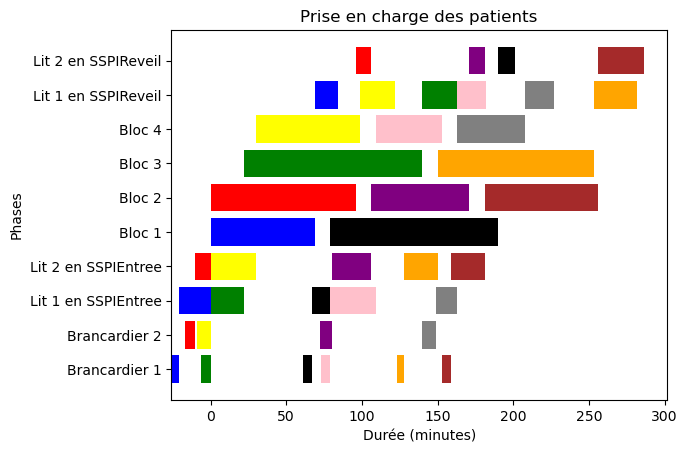

312


In [248]:
def emploiDuTemps(arrangement):
    """Affiche sous forme de diagramme en barre l'emploi du temps global d'un arrangement"""

    titres = [f"Brancardier {i+1}" for i in range(len(arrangement[0]))] + [f"Lit {i+1} en SSPIEntree" for i in range(len(arrangement[1]))] + [f"Bloc {i+1}" for i in range(len(arrangement[2]))] + [f"Lit {i+1} en SSPIReveil" for i in range(len(arrangement[3]))]
    couleurs = ['blue', 'red', 'green', 'yellow', 'black', 'purple', 'pink', 'orange', 'grey', 'brown']

    # Créer un graphique en barres horizontales
    ind = 0
    for phase in arrangement:
        for ressource in phase:
            for patient in ressource:
                plt.barh(titres[ind], left=patient[1], width = patient[2], color=couleurs[patient[0]%10])
            ind += 1

    # Ajouter des étiquettes d'axe et un titre
    plt.xlabel("Durée (minutes)")
    plt.ylabel("Phases")
    plt.title("Prise en charge des patients")

    plt.show()
    
arrangement = arrangementFinal(genOrdo(10))
emploiDuTemps(arrangement)
print(coutOrdo(arrangement))


Remarques : 

- Les nombres de medecins et d'anesthésistes sont ici inutilisés : Puisque nous avons 4 blocs disponibles au maximum, il y a 4 médecins utilisés au maximum, la disponibilité des anesthésistes est inhérente aux durées dans les SSPI. De plus, dans un hopital, les anesthésistes ne sont pas fixes, ils vont de salles en salle pour vérifier que tout va bien ou si ils sont appelés en urgence.
- Ceci n'est pas un résultat final mais un outil pour lequel on fera varier les paramètres de ressources en fonction des vacations et des besoins (par exemple on voit la que les brancardiers ne foutent rien de leur journée => faut-il en mettre qu'un seul ?)

Améliorations : 

- Utiliser cet algorithme pour organiser les vacations des médecins => en fonction du nombre de médecin ouvrir plus ou moins de blocs et faire en sorte que l'on n'ait pas un ordonnancement infini mais qui place les patients dans telle ou telle vacation + créer un algorithme qui détermine combien de places en SSPI et de brancardiers sont nécéssaires pendant une certaine période ?
- Ajouter le calcul de l'attente totale des patients ?


In [230]:
l = [1]
l.insert(-1, 5)
print(l)

[5, 1]
